# <p style='text-align: center;'> Inverted pendulum on a cart</p>

### Importing needed libraries

In [1]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import control.matlab as mt
from IPython.display import clear_output

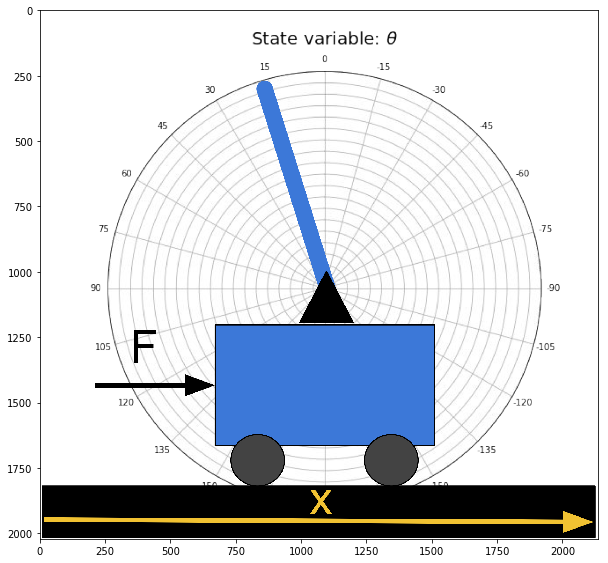

In [2]:
img = mpimg.imread("System1.png")
plt.figure(figsize=(10,10))
plt.imshow(img);

# I. System Modeling 

## Lagrangian Method

$x_m = x -l\ sin\theta,\ \   y_m = l\ cos\theta$
***
$T = \frac{1}{2}M\dot{x}^2 + \frac{1}{2}m(\dot{x}^2_m + \dot{y}^2_m )$ <br>
$\ \ \ = \frac{1}{2}(M+m)\dot{x}^2 + \frac{1}{2}m(l\dot{\theta})^2 - ml\dot{x}\dot{\theta}cos\theta $
***
$V = mglcos\theta$
***
$L= T-V$
***
Lagrang Equations:<br>
x direction : $ F=\frac{d}{dt}(\frac{\partial L}{\partial \dot{x}}) -\frac{\partial L}{\partial x}$ 
$=(M+m)\ddot{x}-ml\ddot{\theta}cos\theta+ml\dot{\theta}^2sin\theta $    (1)<br>

$\theta$ direction : $ 0=\frac{d}{dt}(\frac{\partial L}{\partial \dot{\theta}}) -\frac{\partial L}{\partial \theta}$
$=ml\ddot{x}cos(\theta)-ml^2\ddot{\theta}+glsin\theta$    (2)<br><br>
***
State Equations:<br>
(1)(2)$\Rightarrow$<br>
$\dot{x} = v$<br>
$\dot{\theta} = \omega$<br>
$\dot{v} = (F + m l \omega^2 sin(\theta) + m g sin(\theta) cos(\theta)) / (M + m(1-{cos(theta)}^2))$<br>
$\dot{\omega} = (\ F\ cos\theta - m\ l\ \omega^2\ sin\theta\ cos\theta + (M + m) g\ sin \theta\ )\ /\ 
          (l\  (M + m (1- {cos \theta}^2)))$


## Simulation and Model Evaluation 

Model paramters:<br>
m = 1<br>
M = 1<br>
l = 1<br>

100.0 %


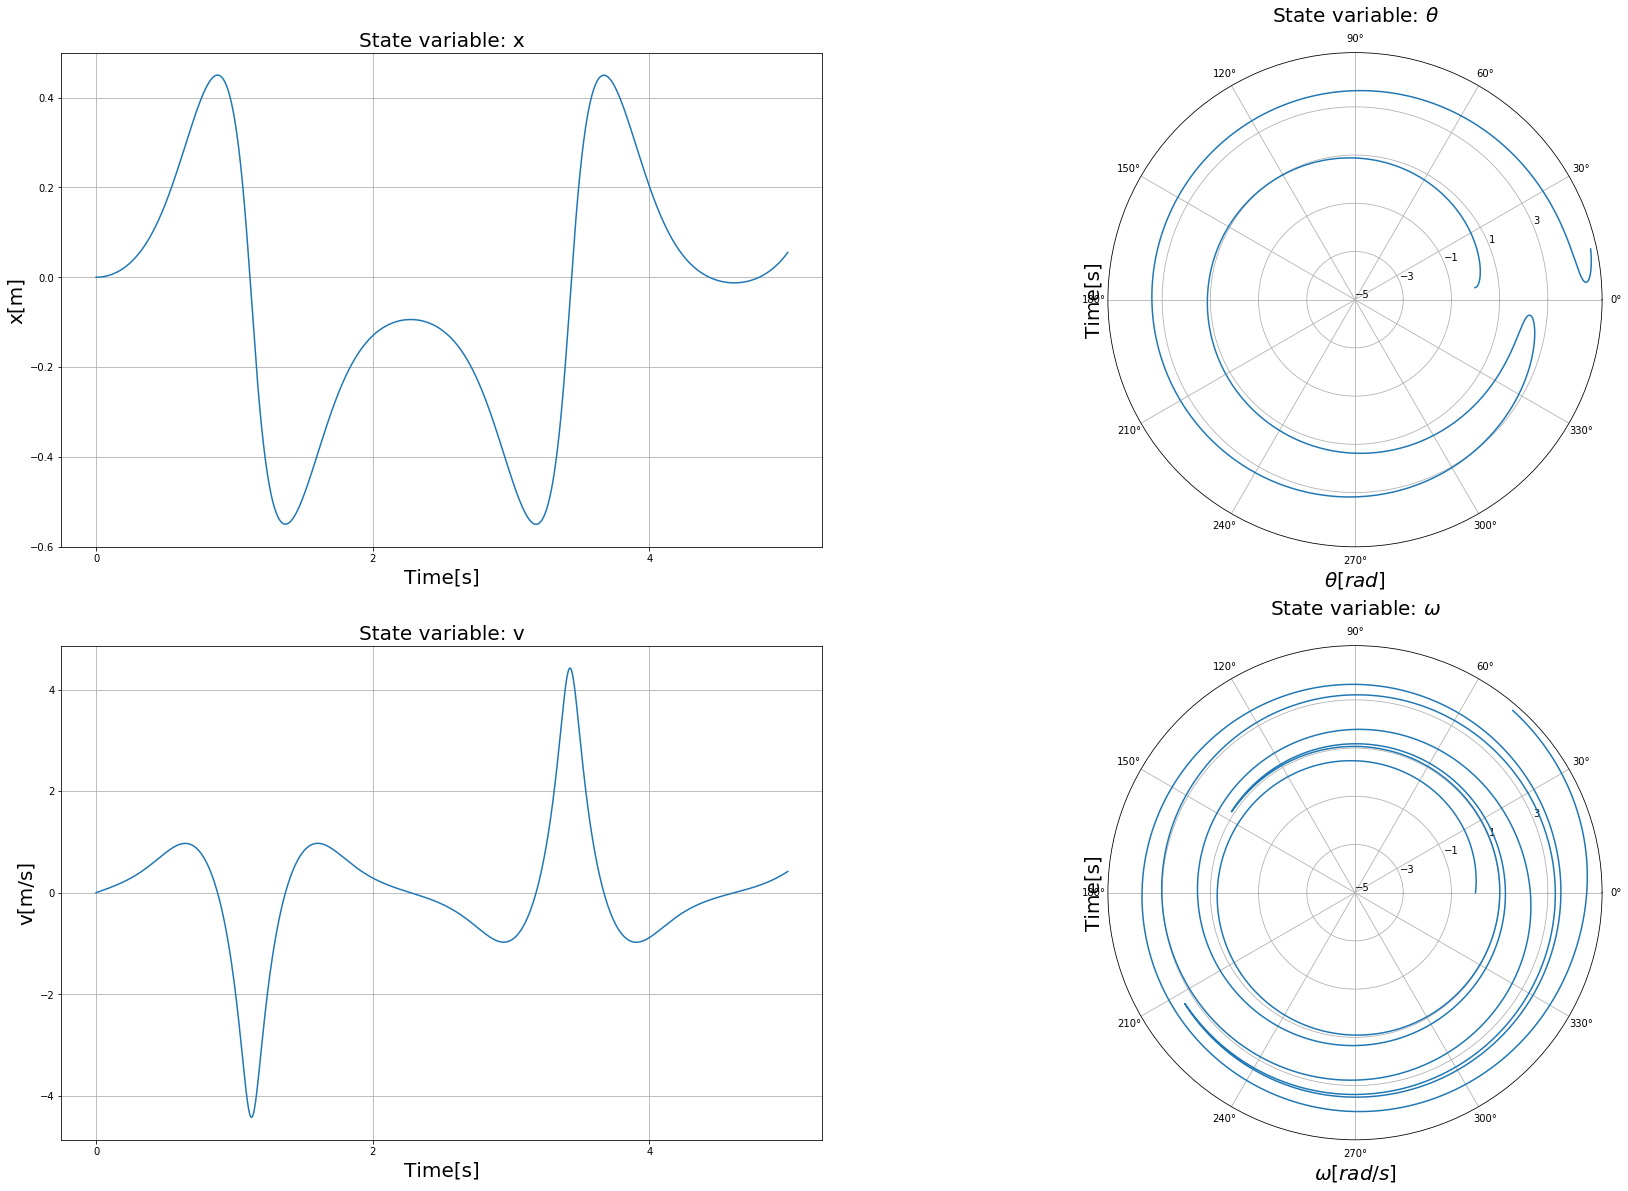

In [3]:
m = 1
M = 1
l = 1
g = 9.8

x = 0
v = 0
theta = 0.1 # 0 : unstable equilibrium
omega = 0
f = 0

x_mem = np.zeros([0])
theta_mem = np.zeros([0])
v_mem = np.zeros([0])
omega_mem = np.zeros([0])
F_mem = np.zeros([0])

Tf = 5
dt = 0.0001
lats_t = 0
time = np.linspace(0,Tf,int(Tf/dt))
for t in time:

    xd = v
    thetad = omega
    
    vd = ((f + m*l*np.power(omega,2)*np.sin(-theta) - m*g*np.sin(-theta)*np.cos(-theta)) /
          (M + m*(1-np.power(np.cos(-theta),2)))) 
    
    omegad = ((f*np.cos(theta) - m*l*np.power(omega,2)*np.sin(theta)*np.cos(theta) + (M + m)*g*np.sin(theta)) /
              (l*(M + m*(1-np.power(np.cos(theta),2)))))
    
    x = x + dt*xd
    theta = theta + dt*thetad
    v = v + dt*vd
    omega = omega + dt*omegad
    
    x_mem = np.append(x_mem,x)
    theta_mem = np.append(theta_mem,theta)
    v_mem = np.append(v_mem,v)
    omega_mem = np.append(omega_mem,omega)
    F_mem = np.append(F_mem,f)
    
    
    if(lats_t != t*100//Tf):
        lats_t = t*100//Tf  
        clear_output(True)
        print(lats_t,"%")
        
plt.figure(figsize=(30,20))

plt.subplot(221)
plt.plot(time,x_mem)
plt.xticks(np.arange(0, Tf, 2))
plt.grid()
plt.title("State variable: x", fontsize=20)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("x[m]", fontsize=20)

plt.subplot(222,projection='polar')
plt.polar(theta_mem,time);
plt.xticks(np.arange(0, np.pi*2,30/180*np.pi))
plt.yticks(np.arange(-5, Tf, 2));
plt.title(r"State variable: $\theta$", fontsize=20)
plt.xlabel(r"$\theta[rad]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20)

plt.subplot(223)
plt.plot(time,v_mem)
plt.xticks(np.arange(0, Tf, 2))
plt.grid()
plt.title("State variable: v", fontsize=20)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("v[m/s]", fontsize=20)

plt.subplot(224,projection='polar')
plt.polar(omega_mem,time);
plt.xticks(np.arange(0, np.pi*2,30/180*np.pi))
plt.yticks(np.arange(-5, Tf, 2));
plt.title(r"State variable: $\omega$", fontsize=20)
plt.xlabel(r"$\omega[rad/s]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20);

### Unstable Equilibrium: $\theta = 0$

# II. Controller Design

## 1. Fuzzifier
   All inputs(i.e sensor data of state variables) are singleton. So fuzzifier is singleton.

## 2. Knowlegebase      

### 2.1. Database

In [4]:
# ============================================================================ Definition of triangular function fuzzy membership
class trimf:
    def __init__(self, a, b, c, ref_set):
        self.a = a
        self.b = b
        self.c = c
        self.ref_set = ref_set
        
    def series(self):
        return fuzz.trimf(self.ref_set, [self.a, self.b, self.c])
    
    
    def doc(self, singleton_input):
        if (singleton_input<=self.a):
            return 0
        
        if (singleton_input>self.a and singleton_input<=self.b):
            return (1/(self.b-self.a)*(singleton_input-self.a))
        
        if (singleton_input>self.b and singleton_input<=self.c):
            return (1-1/(self.c-self.b)*(singleton_input-self.b))
        
        if (singleton_input>self.c):
            return 0
        
# ============================================================================ Definition of trapezoidal function fuzzy membership
class trapmf:
    def __init__(self, a, b, c, d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
# ============================================================================ Definition of Bell function fuzzy membership
class gbellmf:
    def __init__(self, a, b, c, ref_set):
        self.a = a
        self.b = b
        self.c = c
        self.ref_set = ref_set
        
    def series(self):
        return 1 / (1 + abs((self.ref_set - self.c) / self.a) ** (2 * self.b))
    
    def doc(self, singleton_input):
        return 1 / (1 + abs((singleton_input - self.c) / self.a) ** (2 * self.b))
    
# ============================================================================ Definition of sigmoid function fuzzy membership 
class sigmf:
    def __init__(self, b, c, ref_set):
        self.b = b
        self.c = c
        self.ref_set = ref_set
        
    def series(self):
        return 1 / (1. + np.exp(- self.c * (self.ref_set - self.b)))
    
    def doc(self, singleton_input):
        return 1 / (1. + np.exp(- self.c * (singleton_input - self.b)))
    

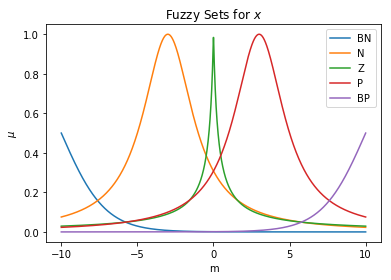

In [5]:
index =["BN", "N", "Z","P", "BP"]
num = 5

# Beginning of interval
boi = -10
# End of interval
eoi = 10
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
A = np.array([sigmf(b=-10, c=-0.7, ref_set=ref),
              gbellmf(a=2 , b=1, c=-3, ref_set=ref),
              gbellmf(a=0.3 , b=0.5, c=0, ref_set=ref),
              gbellmf(a=2 , b=1, c=3, ref_set=ref),
              sigmf(b=10, c= 0.7, ref_set=ref)])

for i in range(num):
    plt.plot(ref, A[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("m")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for $x$")
plt.legend();

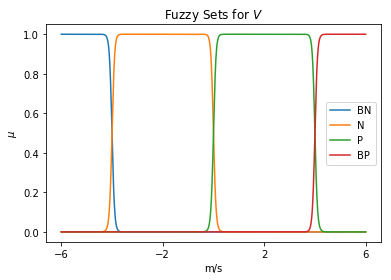

In [6]:
index =["BN", "N", "P", "BP"]
num = 4

# Beginning of interval
boi = -6
# End of interval
eoi = 6
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
B = np.array([sigmf(b=-4,    c=-20, ref_set=ref),
              gbellmf(a=2 , b=20, c=-2, ref_set=ref),
              gbellmf(a=2 , b=20, c=2, ref_set=ref),
              sigmf(b=4,    c= 20, ref_set=ref)])

for i in range(num):
    plt.plot(ref, B[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("m/s")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for $V$")
plt.legend();

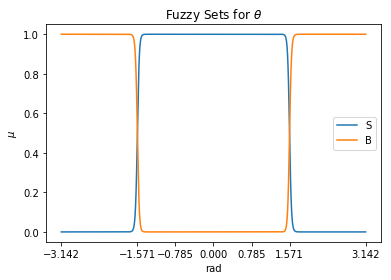

In [7]:
index =["S", "B"]
num = 2

# Beginning of interval
boi = -np.pi
# End of interval
eoi = np.pi
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,int(roi*100))
C = np.array([gbellmf(a=np.pi/2 , b=40, c=0, ref_set=ref),
              gbellmf(a=np.pi/2 , b=-40, c=0, ref_set=ref)])

for i in range(num):
    plt.plot(ref,C[i].series(), label=index[i]) 
    
plt.xticks([-np.pi, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, np.pi])
plt.xlabel("rad")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for $\theta$")
plt.legend();

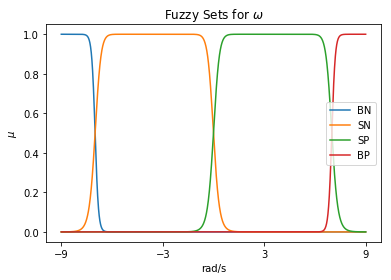

In [8]:
index =["BN","SN", "SP", "BP"]
num = 4

# Beginning of interval
boi = -9
# End of interval
eoi = 9
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*100)
D = np.array([sigmf( b=-7, c=-10, ref_set=ref),
              gbellmf(a=3.5, b=10, c=-3.5, ref_set=ref),
              gbellmf(a=3.5, b=10, c=3.5, ref_set=ref),
              sigmf( b= 7, c=10 , ref_set=ref)])

for i in range(num):
    plt.plot(ref, D[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("rad/s")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for $\omega$")
plt.legend();

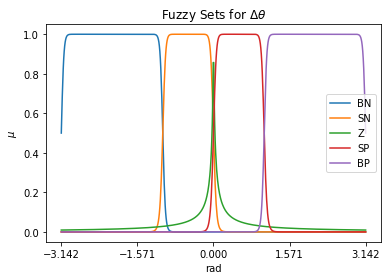

In [9]:
index =["BN","SN", "Z", "SP", "BP"]
num = 5

# Beginning of interval
boi = -np.pi
# End of interval
eoi = np.pi
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,int(roi*100))
E = np.array([gbellmf(a=np.pi/3, b=20,  c=-np.pi*2/3, ref_set=ref),
              gbellmf(a=np.pi/6, b=9,   c=-np.pi/6, ref_set=ref),
              gbellmf(a=0.03,    b=0.5, c=0, ref_set=ref),
              gbellmf(a=np.pi/6, b=9,   c= np.pi/6 , ref_set=ref),
              gbellmf(a=np.pi/3, b=20,  c= np.pi*2/3 , ref_set=ref)])

for i in range(num):
    plt.plot(ref, E[i].series(), label=index[i]) 
    
plt.xticks(np.arange(boi, eoi+ roi/(num-1), roi/(num-1)))
plt.xlabel("rad")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for $\Delta \theta$")
plt.legend();

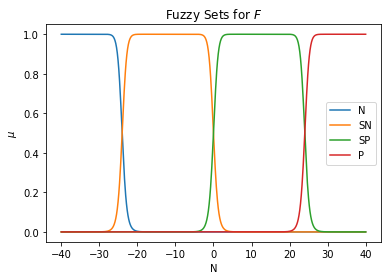

In [10]:
index =["N", "SN", "SP", "P"]

N = 0
SN= 1
# Z = 2
SP= 2
P = 3
num = 4

# Beginning of interval
boi = -40
# End of interval
eoi = 40
# Range of interval
roi = eoi - boi

ref = np.linspace(boi,eoi,roi*10)
F = np.array([gbellmf(a= 12, b=10, c= -36, ref_set=ref),
              gbellmf(a= 12, b=10, c= -12, ref_set=ref),
              gbellmf(a= 12, b=10, c=  12, ref_set=ref),
              gbellmf(a= 12, b=10, c=  36, ref_set=ref)])

Fi = np.array([F[0].series(),
               F[1].series(),
               F[2].series(),
               F[3].series()])

for i in range(num):
    plt.plot(ref,F[i].series(), label=index[i]) 
plt.xlabel("N")
plt.ylabel("$\mu$")
plt.title(r"Fuzzy Sets for $F$")
plt.legend();

### 2.2. Rule Base

What these rules do:
- Accelerate the box toward $x = 0$ by changing  desired degree of pendalum ($\alpha$) <br>
- Accelerate the pendalum and swing it toward $\theta = \alpha$<br>
- Decelerate the pendalum when it is close to the $\alpha$<br>
- Controlling position of the pendulum at neighboring of $\theta = \alpha$
    

In [11]:
             #                     v 
             #BN             N          P            BP
rule_base1= [[-np.pi/32, -np.pi/16,  -np.pi/16,  +np.pi/32],# BN       
             [-np.pi/32, -np.pi/32, -np.pi/100,  +np.pi/32],# N  
             [        0,         0,          0,          0],# Z  x
             [-np.pi/32, +np.pi/100, +np.pi/32,  +np.pi/32],# P  
             [-np.pi/32,  +np.pi/16, +np.pi/16,  +np.pi/32]]# BP   

             #    omega 
             #BN SN  SP  BP      theta
rule_base2=[[[P, SN,  P, SN],     # S      BN           
             [N,  P,  N,  P]],    # B   
            
            [[P,  P,  SP, N],     # S      SN           
             [N,  P,   N, P]],    # B
            
            [[P,  P,  N, N],      # S      Z      error          
             [N,  P,  N, P]],     # B
            
            [[P, SN,   N, N],     # S      SP          
             [N,  P,  N, P]],     # B   
            
            [[SP, N,  SP, N],     # S      BP          
             [N,  P,   N, P]]]    # B   

### 2.3. Inference Mechanism

In [12]:
def fuzzy_controller1(x, v):
    # 1. Degrees of compatibility 
    # 2. Firing Strength: 
    u = np.array([[A[i].doc(x)*B[j].doc(v)
                   for j in range(len(B))]
                  for i in range(len(A))])

    # 3. Qualified (induced) consequent MFs : Algebraic Product implication
    result = np.array( [[rule_base1[i][j]*u[i,j] 
                          for j in range(len(B))]
                         for i in range(len(A))])
    
    # 5. defuzzification : COA
    result  = np.sum(result)/np.sum(u)
    
    return result

In [13]:
def fuzzy_controller2(error, theta, omega, reference_set, consequentFuzzySets):
    # 1. Degrees of compatibility 
    # 2. Firing Strength: 
    u = np.array([[[E[i].doc(error)*C[j].doc(theta)*D[k].doc(omega)
                    for k in range(len(D))] 
                   for j in range(len(C))]
                  for i in range(len(E))])

    # 3. Qualified (induced) consequent MFs : Algebraic Product implication
    resulti = np.array( [[[consequentFuzzySets[rule_base2[i][j][k]]*u[i,j,k] 
                           for k in range(len(D))] 
                          for j in range(len(C))]
                         for i in range(len(E))])
    # 4. Overall output MF : MAX 
    result = resulti [0,0,0]
    for i in range(len(E)):
        for j in range(len(C)):
            for k in range(len(D)):
                result = np.maximum(resulti[i,j,k],result)

    # 5. defuzzification : COA
    if (np.sum(result)>0):
        result  = np.sum(result*reference_set)/np.sum(result)
    else:
        result=0
    
    return result

## 3. Defuzzifier

Defuzzification is implemented in <code>fuzzy_controller()</code> function. Defuzzifier method is Center of Area.   

# III. Simulation

## Case 1 :
$ x_0 = 0$<br>
$ v_0 = 0$<br>
$ \theta_0 = 3.14 $<br>
$ \omega_0 = 0$<br>

100.0 %


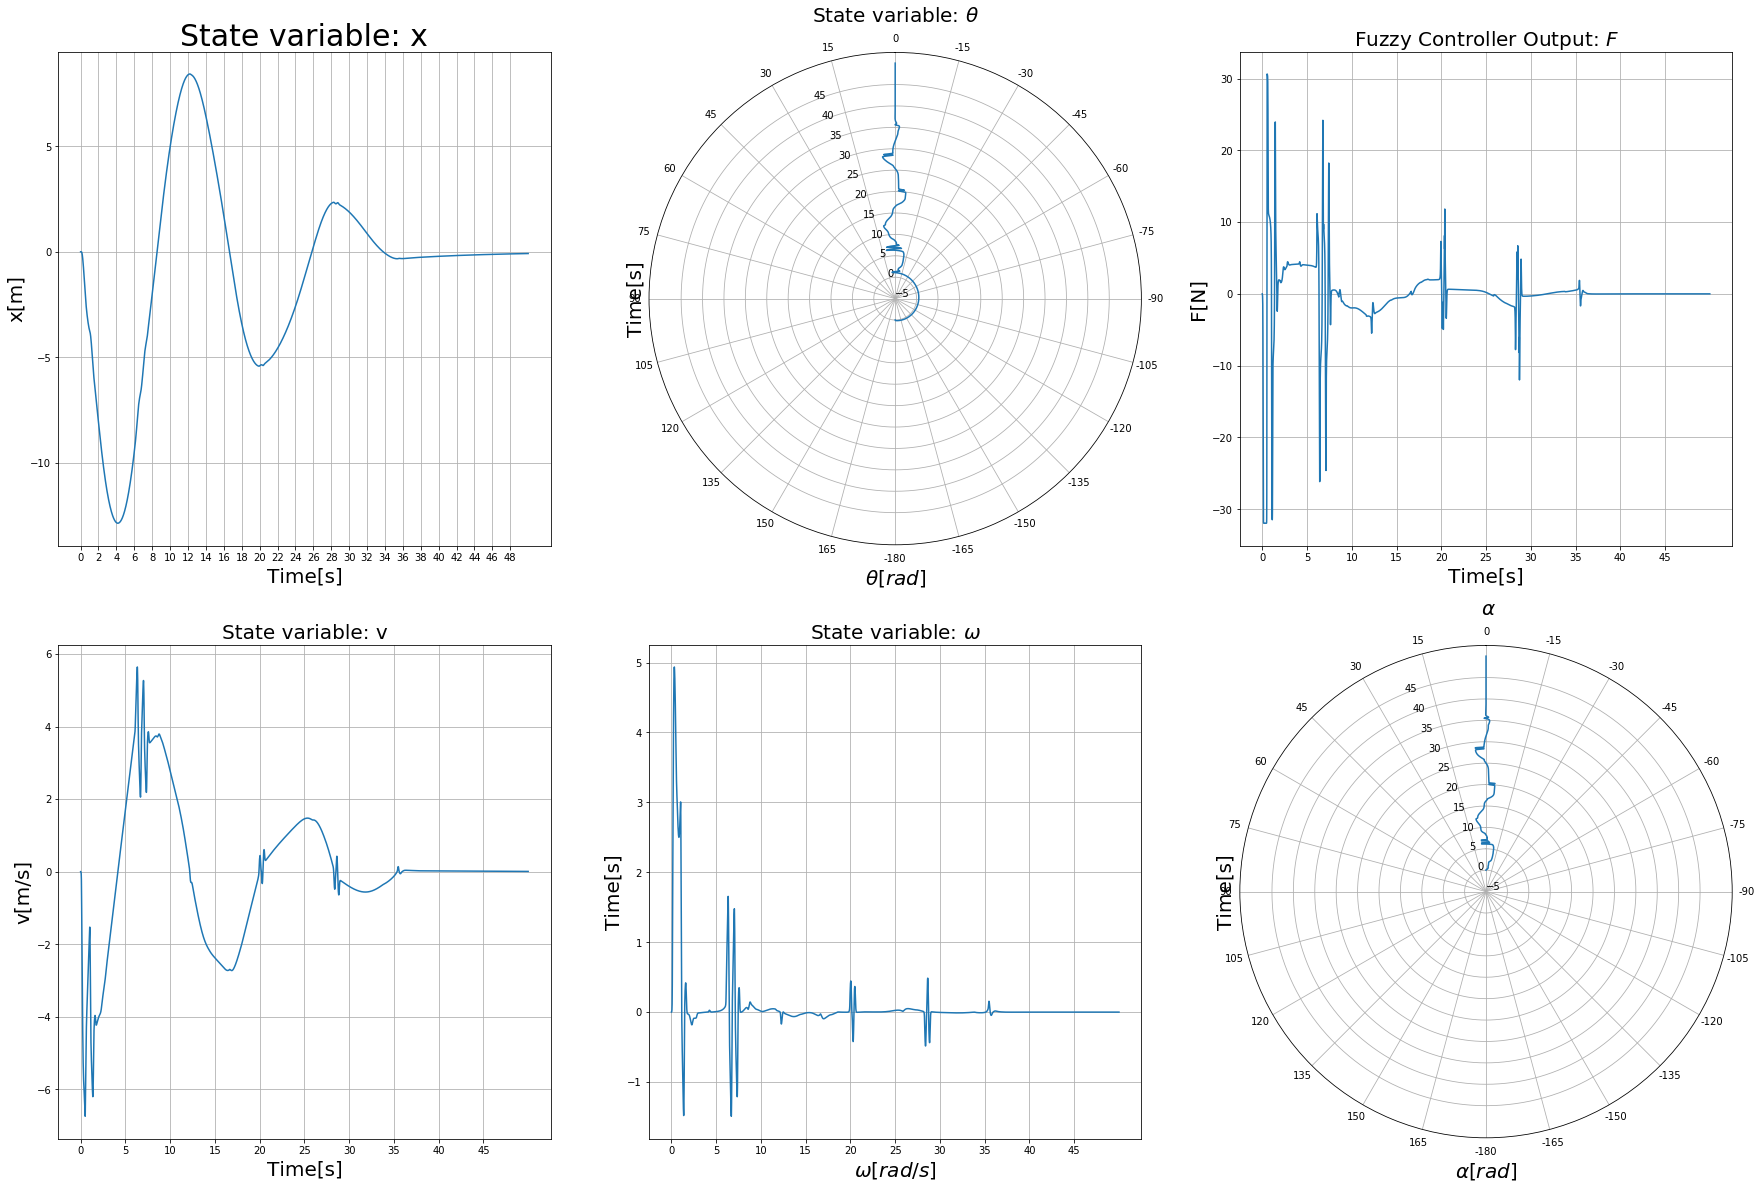

In [14]:
m = 1
M = 1
l = 1  
g = 9.8

x = 0
v = 0
theta = 3.14
omega = 0

alpha = 0
f = 0


x_mem = np.zeros([0])
theta_mem = np.zeros([0])
v_mem = np.zeros([0])
omega_mem = np.zeros([0])
F_mem = np.zeros([0])
alpha_mem = np.zeros([0])

Tf = 50
dt = 0.01
lats_t = 0
time = np.linspace(0,Tf,int(Tf/dt))
for t in time:
    
    alpha = fuzzy_controller1(x,v)
    
    deg = theta % (2*np.pi)
    if(deg>np.pi):
        deg = deg - 2*np.pi
    if(deg<-np.pi):
        deg = deg + 2*np.pi

    error = deg - alpha 
    
    f = fuzzy_controller2(error, deg, omega, F[0].ref_set, Fi)

    xd = v
    thetad = omega
    
    vd = ((f + m*l*np.power(omega,2)*np.sin(-theta) - m*g*np.sin(-theta)*np.cos(-theta)) /
          (M + m*(1-np.power(np.cos(-theta),2)))) 
    
    omegad = ((f*np.cos(theta) - m*l*np.power(omega,2)*np.sin(theta)*np.cos(theta) + (M + m)*g*np.sin(theta)) /
              (l*(M + m*(1-np.power(np.cos(theta),2)))))
    
    x = x + dt*xd
    theta = theta + dt*thetad
    v = v + dt*vd
    omega = omega + dt*omegad
    
    x_mem = np.append(x_mem,x)
    theta_mem = np.append(theta_mem,theta)
    v_mem = np.append(v_mem,v)
    omega_mem = np.append(omega_mem,omega)
    F_mem = np.append(F_mem,f)
    alpha_mem = np.append(alpha_mem,alpha)
    
    
    if(lats_t != t*100//Tf):
        lats_t = t*100//Tf  
        clear_output(True)
        print(lats_t,"%")
        
plt.figure(figsize=(30,20))

plt.subplot(231)
plt.plot(time,x_mem)
plt.xticks(np.arange(0, Tf, 2))
plt.grid()
plt.title("State variable: x", fontsize=30)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("x[m]", fontsize=20)

plt.subplot(232,projection='polar')
plt.polar(theta_mem,time);
ax=plt.gca() 
ax.set_theta_zero_location('N')
plt.xticks(np.arange(0, np.pi*2, 15/180*np.pi), np.concatenate([np.arange(0,180,15),np.arange(-180,0,15)]))
plt.yticks(np.arange(-5, Tf, Tf/10))
plt.title(r"State variable: $\theta$", fontsize=20)
plt.xlabel(r"$\theta[rad]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20)

plt.subplot(233)
plt.plot(time, F_mem);
plt.xticks(np.arange(0, Tf,  Tf/10))

plt.grid()
plt.title(r"Fuzzy Controller Output: $F$", fontsize=20)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("F[N]", fontsize=20)

plt.subplot(234)
plt.plot(time,v_mem)
plt.xticks(np.arange(0, Tf, Tf/10))
plt.grid()
plt.title("State variable: v", fontsize=20)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("v[m/s]", fontsize=20)

plt.subplot(235)
plt.plot(time,omega_mem);
plt.xticks(np.arange(0, Tf, Tf/10));
plt.grid()
plt.title(r"State variable: $\omega$", fontsize=20)
plt.xlabel(r"$\omega[rad/s]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20);

plt.subplot(236,projection='polar')
plt.polar(alpha_mem,time);
ax=plt.gca() 
ax.set_theta_zero_location('N')
plt.xticks(np.arange(0, np.pi*2, 15/180*np.pi), np.concatenate([np.arange(0,180,15),np.arange(-180,0,15)]))
plt.yticks(np.arange(-5, Tf, Tf/10))
plt.title(r" $\alpha$", fontsize=20)
plt.xlabel(r"$\alpha[rad]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20);

## Case 2 :
$ x_0 = -10$<br>
$ v_0 = -10$<br>
$ \theta_0 = 1 $<br>
$ \omega_0 = 10$<br>

100.0 %


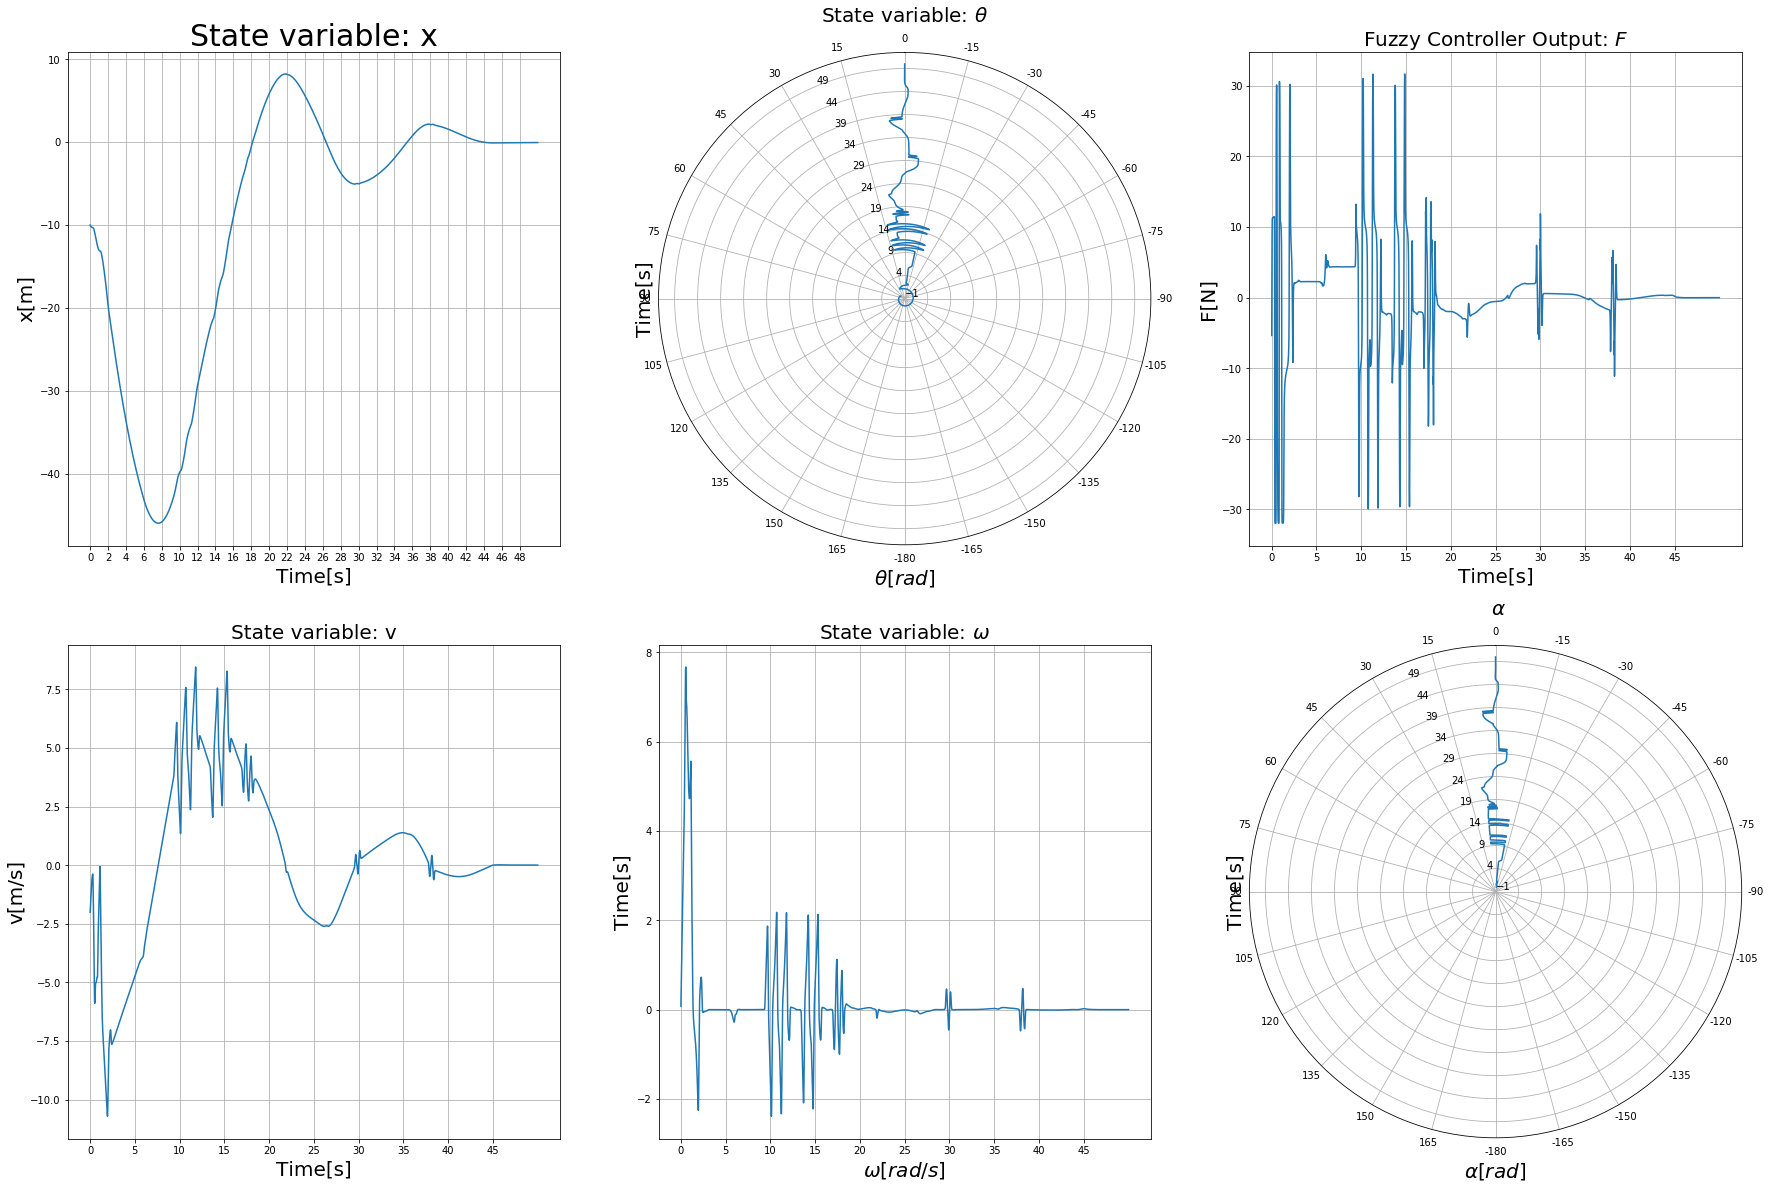

In [15]:
m = 1
M = 1
l = 1  
g = 9.8

x = -10
v = -2
theta = 1
omega = 0

alpha = 0
f = 0


x_mem = np.zeros([0])
theta_mem = np.zeros([0])
v_mem = np.zeros([0])
omega_mem = np.zeros([0])
F_mem = np.zeros([0])
alpha_mem = np.zeros([0])

Tf = 50
dt = 0.01
lats_t = 0
time = np.linspace(0,Tf,int(Tf/dt))
for t in time:
    
    alpha = fuzzy_controller1(x,v)
    
    deg = theta % (2*np.pi)
    if(deg>np.pi):
        deg = deg - 2*np.pi
    if(deg<-np.pi):
        deg = deg + 2*np.pi

    error = deg - alpha 
    
    f = fuzzy_controller2(error, deg, omega, F[0].ref_set, Fi)

    xd = v
    thetad = omega
    
    vd = ((f + m*l*np.power(omega,2)*np.sin(-theta) - m*g*np.sin(-theta)*np.cos(-theta)) /
          (M + m*(1-np.power(np.cos(-theta),2)))) 
    
    omegad = ((f*np.cos(theta) - m*l*np.power(omega,2)*np.sin(theta)*np.cos(theta) + (M + m)*g*np.sin(theta)) /
              (l*(M + m*(1-np.power(np.cos(theta),2)))))
    
    x = x + dt*xd
    theta = theta + dt*thetad
    v = v + dt*vd
    omega = omega + dt*omegad
    
    x_mem = np.append(x_mem,x)
    theta_mem = np.append(theta_mem,theta)
    v_mem = np.append(v_mem,v)
    omega_mem = np.append(omega_mem,omega)
    F_mem = np.append(F_mem,f)
    alpha_mem = np.append(alpha_mem,alpha)
    
    
    if(lats_t != t*100//Tf):
        lats_t = t*100//Tf  
        clear_output(True)
        print(lats_t,"%")
        
plt.figure(figsize=(30,20))

plt.subplot(231)
plt.plot(time,x_mem)
plt.xticks(np.arange(0, Tf, 2))
plt.grid()
plt.title("State variable: x", fontsize=30)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("x[m]", fontsize=20)

plt.subplot(232,projection='polar')
plt.polar(theta_mem,time);
ax=plt.gca() 
ax.set_theta_zero_location('N')
plt.xticks(np.arange(0, np.pi*2, 15/180*np.pi), np.concatenate([np.arange(0,180,15),np.arange(-180,0,15)]))
plt.yticks(np.arange(-1, Tf, Tf/10))
plt.title(r"State variable: $\theta$", fontsize=20)
plt.xlabel(r"$\theta[rad]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20)

plt.subplot(233)
plt.plot(time, F_mem);
plt.xticks(np.arange(0, Tf,  Tf/10))

plt.grid()
plt.title(r"Fuzzy Controller Output: $F$", fontsize=20)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("F[N]", fontsize=20)

plt.subplot(234)
plt.plot(time,v_mem)
plt.xticks(np.arange(0, Tf, Tf/10))
plt.grid()
plt.title("State variable: v", fontsize=20)
plt.xlabel("Time[s]", fontsize=20)
plt.ylabel("v[m/s]", fontsize=20)

plt.subplot(235)
plt.plot(time,omega_mem);
plt.xticks(np.arange(0, Tf, Tf/10));
plt.grid()
plt.title(r"State variable: $\omega$", fontsize=20)
plt.xlabel(r"$\omega[rad/s]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20);

plt.subplot(236,projection='polar')
plt.polar(alpha_mem,time);
ax=plt.gca() 
ax.set_theta_zero_location('N')
plt.xticks(np.arange(0, np.pi*2, 15/180*np.pi), np.concatenate([np.arange(0,180,15),np.arange(-180,0,15)]))
plt.yticks(np.arange(-1, Tf, Tf/10))
plt.title(r" $\alpha$", fontsize=20)
plt.xlabel(r"$\alpha[rad]$", fontsize=20)
plt.ylabel("Time[s]", fontsize=20);